In [76]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-hold-energy-data/D202.csv
/kaggle/input/house-hold-energy-data/D202.xlsx


In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 

plt.style.use('Solarize_Light2')

In [78]:
df = pd.read_csv('/kaggle/input/house-hold-energy-data/D202.csv')
df.head()

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
0,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,$0.00,NaN
1,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,$0.00,NaN
2,Electric usage,10/22/2016,0:30,0:44,0.01,kWh,$0.00,NaN
3,Electric usage,10/22/2016,0:45,0:59,0.01,kWh,$0.00,NaN
4,Electric usage,10/22/2016,1:00,1:14,0.01,kWh,$0.00,NaN


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70368 entries, 0 to 70367
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TYPE        70368 non-null  object 
 1   DATE        70368 non-null  object 
 2   START TIME  70368 non-null  object 
 3   END TIME    70368 non-null  object 
 4   USAGE       70368 non-null  float64
 5   UNITS       70368 non-null  object 
 6   COST        70368 non-null  object 
 7   NOTES       0 non-null      float64
dtypes: float64(2), object(6)
memory usage: 4.3+ MB


In [80]:
for column in range (0,len(df.columns)):
    print(df.columns[column], " n unique values : ", df[df.columns[column]].nunique())

TYPE  n unique values :  1
DATE  n unique values :  733
START TIME  n unique values :  96
END TIME  n unique values :  96
USAGE  n unique values :  200
UNITS  n unique values :  1
COST  n unique values :  49
NOTES  n unique values :  0


In [81]:
df = df.drop(labels=['NOTES'], axis=1)
df.head()

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST
0,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,$0.00
1,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,$0.00
2,Electric usage,10/22/2016,0:30,0:44,0.01,kWh,$0.00
3,Electric usage,10/22/2016,0:45,0:59,0.01,kWh,$0.00
4,Electric usage,10/22/2016,1:00,1:14,0.01,kWh,$0.00


In [82]:
df.isna().sum()

TYPE          0
DATE          0
START TIME    0
END TIME      0
USAGE         0
UNITS         0
COST          0
dtype: int64

In [83]:
df.shape

(70368, 7)

<h3>Deleting dollar sign and converting "cost" in float </h3>

In [84]:
for row in range (0, len(df)):
    df["COST"][row] = df["COST"][row][1:]

df["COST"][:5]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0    0.00 
1    0.00 
2    0.00 
3    0.00 
4    0.00 
Name: COST, dtype: object

In [85]:
df["COST"] = df["COST"].astype("float")
df["COST"].dtype

dtype('float64')

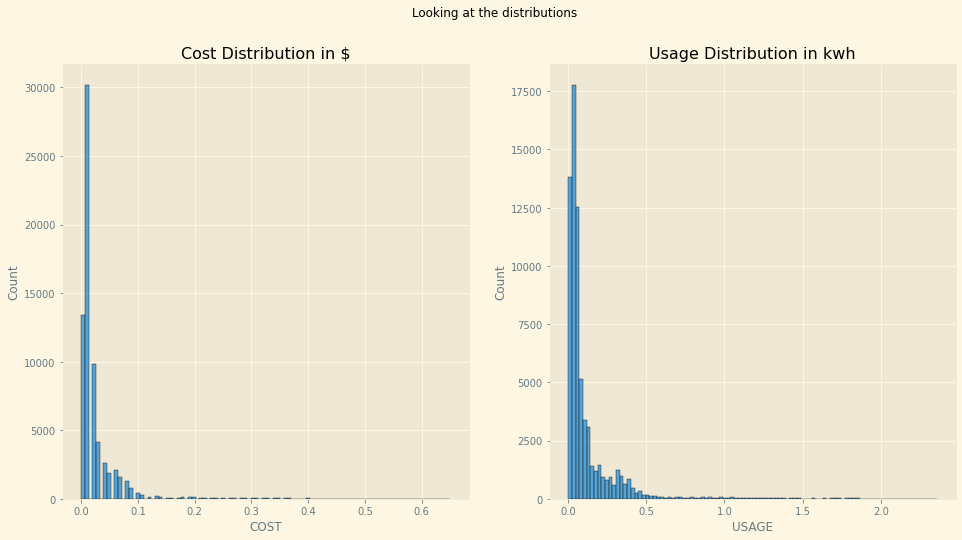

In [86]:
fig, axes = plt.subplots(1,2,figsize=(16, 8))

axes[0].set_title("Cost Distribution in $",color='black')
sns.histplot(df['COST'],bins = 100, ax=axes[0])
axes[1].set_title("Usage Distribution in kwh",color='black')
sns.histplot(df['USAGE'],bins = 100,ax=axes[1])
fig.suptitle('Looking at the distributions',color='black')
plt.show()

<h3>Preprocessing</h3>

In [87]:
df['MODIFIED_DATE'] = df['DATE']+df['START TIME']
df.head()

for index, date in enumerate(df['DATE']):
    df['MODIFIED_DATE'][index] = date+' '+df['START TIME'][index]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [88]:
pd.to_datetime(df['MODIFIED_DATE']).head()

0   2016-10-22 00:00:00
1   2016-10-22 00:15:00
2   2016-10-22 00:30:00
3   2016-10-22 00:45:00
4   2016-10-22 01:00:00
Name: MODIFIED_DATE, dtype: datetime64[ns]

In [89]:
df['MODIFIED_DATE'] = pd.DatetimeIndex(pd.date_range('2016-10-22 00:00:00', periods=len(df), freq='15min'))
df = df.set_index('MODIFIED_DATE')

In [90]:
df['YEAR'] = df.index.year
df['MONTH'] = df.index.month
df['DAY'] = df.index.day
df['WEEKDAY'] = df.index.day_name()
df['WEEKOFYEAR'] = df.index.weekofyear
df['HOUR'] = df.index.hour
df['MINUTE'] = df.index.minute

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  """


In [91]:
df.head(2)

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,YEAR,MONTH,DAY,WEEKDAY,WEEKOFYEAR,HOUR,MINUTE
MODIFIED_DATE,,,,,,,,,,,,,,
2016-10-22 00:00:00,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,0.0,2016,10,22,Saturday,42,0,0
2016-10-22 00:15:00,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,0.0,2016,10,22,Saturday,42,0,15


Text(0.5, 1.0, 'COST per week on a year')

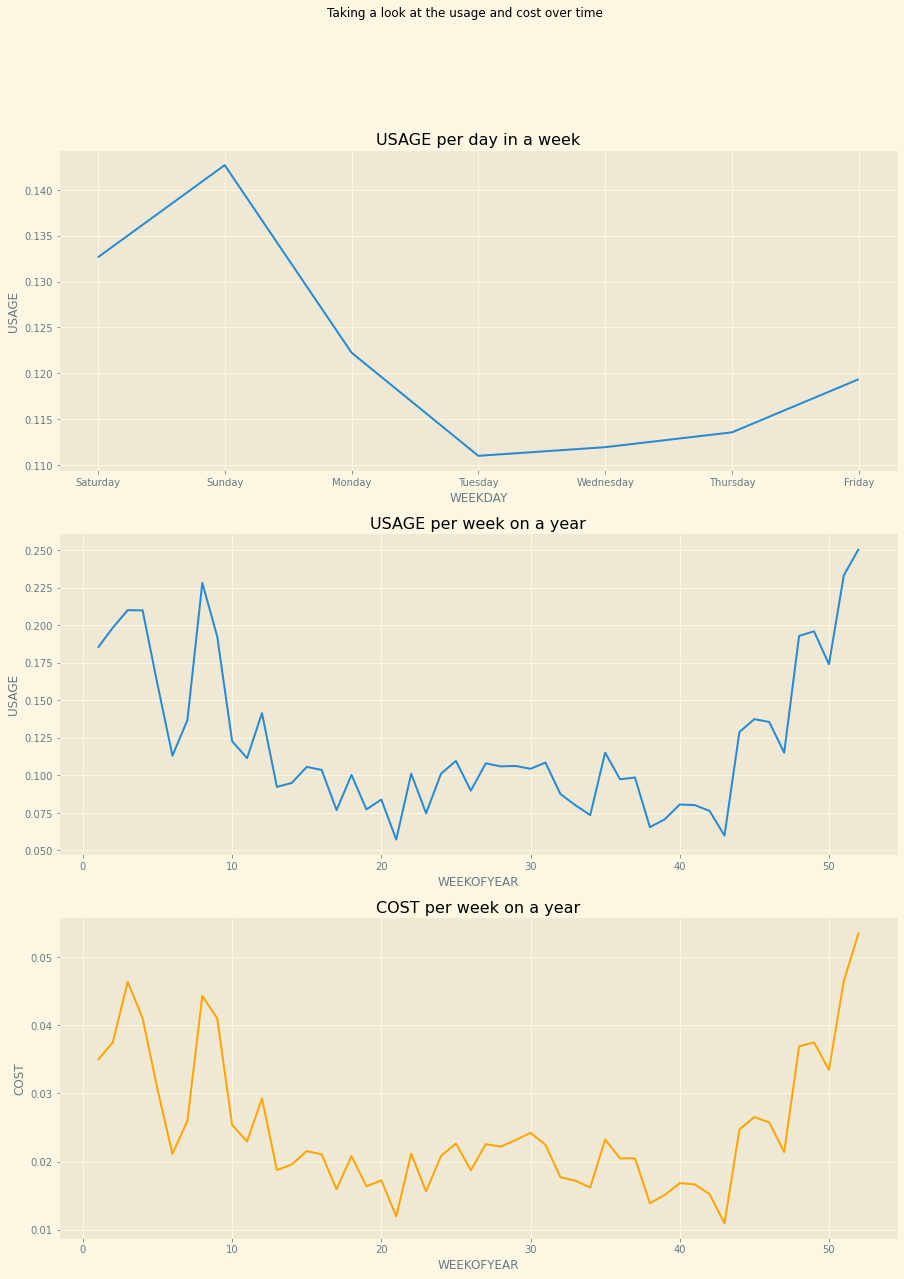

In [92]:
fig, axes = plt.subplots(3,1,figsize=(15, 20))
plt.suptitle('Taking a look at the usage and cost over time',color='black')
sns.lineplot(data = df, x='WEEKDAY', y='USAGE', ci=None, ax=axes[0])
axes[0].set_title('USAGE per day in a week',color='black')
sns.lineplot(data = df, x='WEEKOFYEAR', y='USAGE', ci=None, ax=axes[1])
axes[1].set_title('USAGE per week on a year',color='black')
sns.lineplot(data = df, x='WEEKOFYEAR', y='COST', ci=None, ax=axes[2], color='orange')
axes[2].set_title('COST per week on a year',color='black')

<h3>Spliting our dataset into train and test</h3>

In [93]:
print(df['DATE'][0], ' -> ', df['DATE'][len(df)-1], ', this represents ', (pd.to_datetime(df['DATE'][len(df)-1])-pd.to_datetime(df['DATE'][0])).days, ' days')

10/22/2016  ->  10/24/2018 , this represents  732  days


In [94]:
train = df.loc[df.index < '01-01-2018']
test = df.loc[df.index >= '01-01-2018']

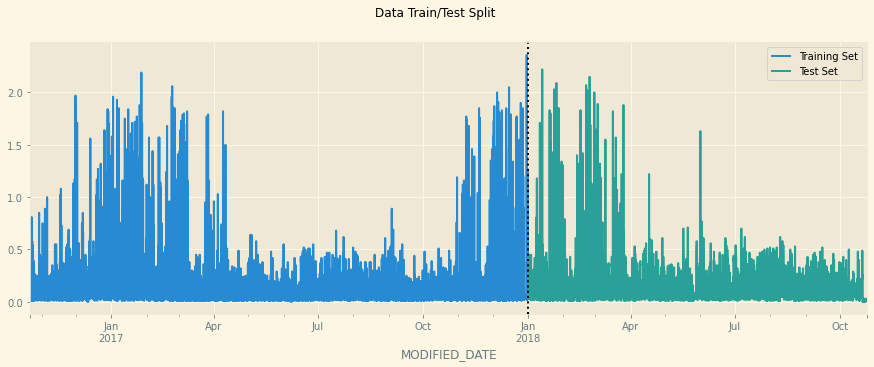

In [95]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(y='USAGE',ax=ax, label='Training Set')
test.plot(y='USAGE',ax=ax, label='Test Set')
plt.suptitle('Data Train/Test Split', color='black')
ax.axvline('01-01-2018', color='black', ls=':')
ax.legend(['Training Set', 'Test Set'])
plt.show()

<h3>Features creation</h3>

In [96]:
features = ['YEAR','MONTH','DAY','WEEKDAY','WEEKOFYEAR','HOUR','MINUTE']
target = 'USAGE'

x_train = train[features]
y_train = train[target]

x_test = test[features]
y_test = test[target]


In [97]:
xgb_model = xgb.XGBRegressor(learning_rate=0.005, n_estimators=1000, early_stopping_rounds=50, booster='gbtree',objective='reg:linear')
xgb_model.fit(x_train._get_numeric_data(), y_train,eval_set=[(x_train._get_numeric_data(), y_train), (x_test._get_numeric_data(), y_test)],verbose=100)

xgb_model.predict(x_train._get_numeric_data())
score = xgb_model.score(x_train._get_numeric_data(), y_train) 
print("Training score: ", score)

[21:13:38] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.43669	validation_1-rmse:0.42242
[100]	validation_0-rmse:0.31153	validation_1-rmse:0.28627
[200]	validation_0-rmse:0.24890	validation_1-rmse:0.21860
[300]	validation_0-rmse:0.21948	validation_1-rmse:0.18863
[400]	validation_0-rmse:0.20555	validation_1-rmse:0.17695
[500]	validation_0-rmse:0.19812	validation_1-rmse:0.17328
[600]	validation_0-rmse:0.19359	validation_1-rmse:0.17273
[653]	validation_0-rmse:0.19165	validation_1-rmse:0.17297
Training score:  0.3025815860754528


In [98]:
y_pred = xgb_model.predict(x_test._get_numeric_data())
mse = mean_squared_error(y_test, y_pred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 0.03
RMSE: 0.17


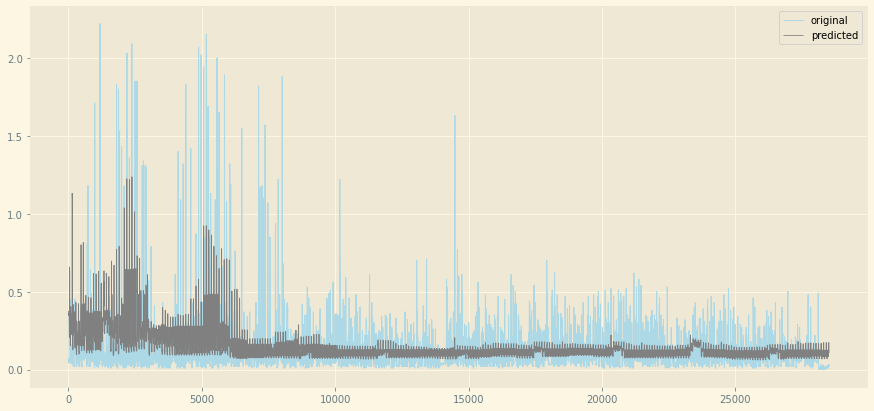

In [99]:
x_ax = range(len(y_test))
fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(x_ax, y_test, lw=1, color="lightblue", label="original")
plt.plot(x_ax, y_pred, lw=0.8, color="grey", label="predicted")
plt.legend()
plt.show()

<h3>Merging predicted values to the main dataframe</h3>

In [100]:
date_pred = pd.DataFrame(y_test)
date_pred.index

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 00:15:00',
               '2018-01-01 00:30:00', '2018-01-01 00:45:00',
               '2018-01-01 01:00:00', '2018-01-01 01:15:00',
               '2018-01-01 01:30:00', '2018-01-01 01:45:00',
               '2018-01-01 02:00:00', '2018-01-01 02:15:00',
               ...
               '2018-10-24 21:30:00', '2018-10-24 21:45:00',
               '2018-10-24 22:00:00', '2018-10-24 22:15:00',
               '2018-10-24 22:30:00', '2018-10-24 22:45:00',
               '2018-10-24 23:00:00', '2018-10-24 23:15:00',
               '2018-10-24 23:30:00', '2018-10-24 23:45:00'],
              dtype='datetime64[ns]', name='MODIFIED_DATE', length=28512, freq=None)

In [101]:
df_pred = pd.DataFrame(data = {'date_pred' : date_pred.index, 'y_pred': y_pred}, index =  date_pred.index )

In [102]:
df = df.merge(df_pred['y_pred'], how='left', left_index=True, right_index=True)

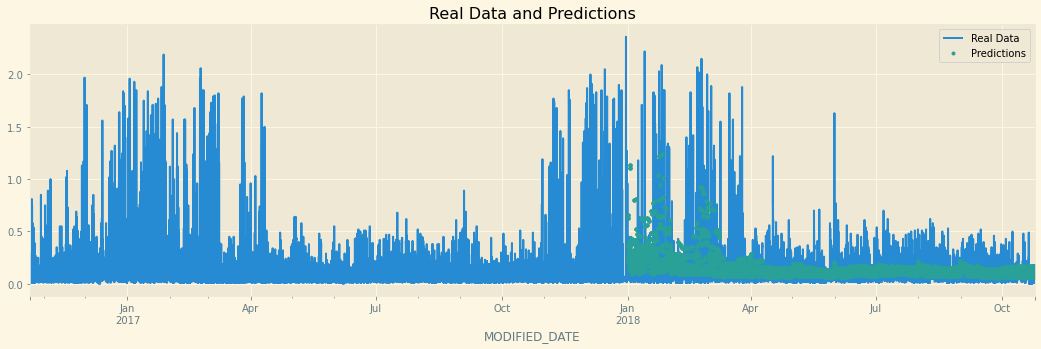

In [103]:
ax = df[['USAGE']].plot(figsize=(18, 5))
df['y_pred'].plot(ax=ax, style='.')
plt.legend(['Real Data', 'Predictions'])
ax.set_title('Real Data and Predictions')
plt.show()

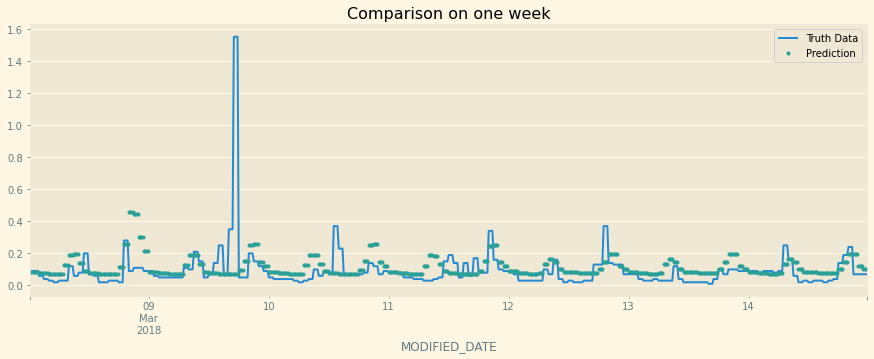

In [106]:
ax = df.loc[(df.index > '03-08-2018') & (df.index < '03-15-2018')]['USAGE'].plot(figsize=(15, 5), title='Comparison on one week')
df.loc[(df.index > '03-08-2018') & (df.index < '03-15-2018')]['y_pred'].plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()